# GBM Tuning

This script is meant to show an example of gbm tuning.  It is based off of this blog post: http://blog.h2o.ai/2016/06/h2o-gbm-tuning-tutorial-for-r/


In [1]:
# Launch H2O Cluster
import h2o
h2o.init(nthreads = -1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-macosx) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-macosx) (build 25.121-b15, mixed mode)
  Starting server from /Users/bear/anaconda/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp19sun0ta
  JVM stdout: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp19sun0ta/h2o_bear_started_from_python.out
  JVM stderr: /var/folders/lh/42j8mfjx069d1bkc2wlf2pw40000gn/T/tmp19sun0ta/h2o_bear_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.3
H2O cluster version age:,25 days
H2O cluster name:,H2O_from_python_bear_77kfxl
H2O cluster total nodes:,1
H2O cluster free memory:,3.556 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [2]:
# Import data
df = h2o.import_file(path = "kaggle_data/titanic.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
df.types

{'age': 'real',
 'boat': 'int',
 'body': 'int',
 'cabin': 'enum',
 'embarked': 'enum',
 'fare': 'real',
 'home.dest': 'enum',
 'name': 'string',
 'parch': 'int',
 'pclass': 'int',
 'sex': 'enum',
 'sibsp': 'int',
 'survived': 'int',
 'ticket': 'int'}

In [4]:
# Convert some integer columns to factor/categorical
df["survived"] = df["survived"].asfactor()
df["ticket"] = df["ticket"].asfactor()

In [5]:
# Set predictors and response variable
response = "survived"

predictors = df.columns
predictors.remove("survived")
predictors.remove("name")
predictors.remove("ticket")
predictors.remove("home.dest")

In [6]:
# Split the data for machine learning
splits = df.split_frame(ratios = [0.6, 0.2], 
                        destination_frames = ["train.hex", "valid.hex", "test.hex"],
                        seed = 1234)

train = splits[0]
valid = splits[1]
test = splits[2]

In [7]:
# Establish a Baseline

from h2o.estimators import H2OGeneralizedLinearEstimator
glm_model = H2OGeneralizedLinearEstimator(family = "binomial", 
                                          model_id = "glm_default.hex")
glm_model.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [8]:
from h2o.estimators import H2ORandomForestEstimator
drf_model = H2ORandomForestEstimator(model_id = "drf_default.hex")
drf_model.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [9]:
from h2o.estimators import H2OGradientBoostingEstimator
gbm_model = H2OGradientBoostingEstimator(model_id = "gbm_default.hex")
gbm_model.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [10]:
from h2o.estimators import H2ODeepLearningEstimator
dl_model = H2ODeepLearningEstimator(model_id = "dl_default.hex")
dl_model.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [11]:
header = ["Model", "Training AUC", "Validation AUC"]
table = [
    ["GLM", glm_model.auc(train = True), glm_model.auc(valid = True)],
    ["DRF", drf_model.auc(train = True), drf_model.auc(valid = True)],
    ["GBM", gbm_model.auc(train = True), gbm_model.auc(valid = True)],
    ["DL", dl_model.auc(train = True), dl_model.auc(valid = True)]
]
h2o.display.H2ODisplay(table, header)

Model,Training AUC,Validation AUC
GLM,0.8610997,0.8381798
DRF,0.9583434,0.9590025
GBM,0.9864197,0.9519865
DL,0.9598242,0.9273880


Model,Training AUC,Validation AUC
GLM,0.8610997,0.8381798
DRF,0.9583434,0.9590025
GBM,0.9864197,0.9519865
DL,0.9598242,0.9273880


PartialDependencePlot progress: |█████████████████████████████████████████| 100%
PartialDependence: Partial Dependence Plot of model gbm_default.hex on column 'sex'



sex,mean_response,stddev_response,std_error_mean_response
female,0.5205867,0.3412708,0.0122195
male,0.3389699,0.4109822,0.0147155


PartialDependence: Partial Dependence Plot of model gbm_default.hex on column 'age'



age,mean_response,stddev_response,std_error_mean_response
0.4167,0.4164890,0.3995985,0.0143079
4.3947684,0.4164890,0.3995985,0.0143079
8.3728368,0.4125693,0.4004596,0.0143388
12.3509053,0.3798753,0.4205084,0.0150566
16.3289737,0.3818186,0.4157351,0.0148857
20.3070421,0.3807028,0.4159284,0.0148926
24.2851105,0.3820088,0.4170167,0.0149316
28.2631789,0.3820121,0.4170215,0.0149318
32.2412474,0.3791999,0.4232424,0.0151545
36.2193158,0.3658808,0.4246647,0.0152054


[, ]

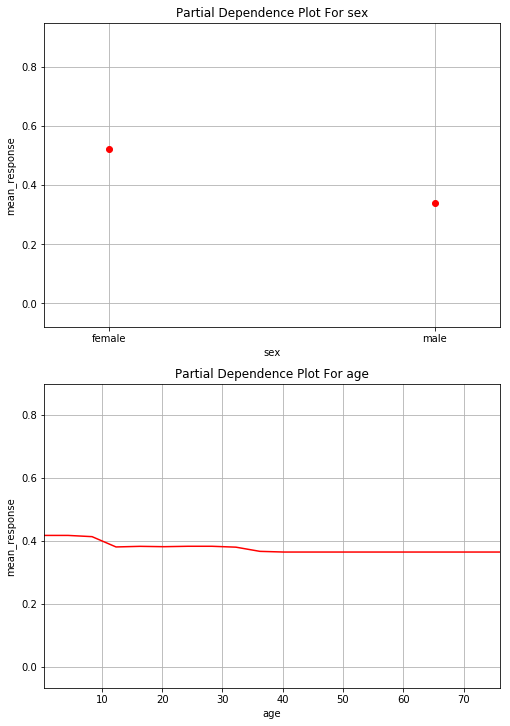

In [12]:
# Investigate GBM Model
%matplotlib inline
gbm_model.partial_plot(train, cols = ["sex", "age"], plot = True, plot_stddev = False)

In [13]:
# Decrease Learning Rate
gbm_learn_rate = H2OGradientBoostingEstimator(learn_rate = 0.05,
                                              model_id = "gbm_learnrate.hex")
gbm_learn_rate.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [14]:
print("Learn Rate AUC: " + str(gbm_learn_rate.auc(valid = True)))

Learn Rate AUC: 0.9489151873767259


In [15]:
# Use Early Stopping

# Early stopping once the moving average (window length = 5) of the validation AUC 
# doesn’t improve by at least 0.1% for 5 consecutive scoring events
    
gbm_early_stopping = H2OGradientBoostingEstimator(learn_rate = 0.05,
                                                  score_tree_interval = 10, 
                                                  stopping_rounds = 5, 
                                                  stopping_metric = "AUC", 
                                                  stopping_tolerance = 0.001,
                                                  ntrees = 5000,
                                                  model_id = "gbm_early_stopping.hex")
gbm_early_stopping.train(x = predictors, y = response, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [16]:
print("Early Stopping AUC: " + str(gbm_early_stopping.auc(valid = True)))

Early Stopping AUC: 0.9663285432516201


In [17]:
# Import H2O Grid Search
from h2o.grid.grid_search import H2OGridSearch

# Use Cartesian Grid Search to find best max depth
# Max depth can have a big impact on training time so we will first narrow down the best max depths

hyper_params = {'max_depth' : list(range(1, 25, 2))}

gbm_grid = H2OGradientBoostingEstimator(
    ## more trees is better if the learning rate is small enough 
    ## here, use "more than enough" trees - we have early stopping
    ntrees = 5000, 
    
    ## smaller learning rate is better
    ## since we have learning_rate_annealing, we can afford to start with a bigger learning rate
    learn_rate = 0.05,                                                         
    
    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
    ## (use 1.00 to disable, but then lower the learning_rate)
    learn_rate_annealing = 0.99,                                               
    
    ## sample 80% of rows per tree
    sample_rate = 0.8,                                                       
   
    ## sample 80% of columns per split
    col_sample_rate = 0.8, 
    
    ## fix a random number generator seed for reproducibility
    seed = 1234,                                                             
    
    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5,
    stopping_tolerance = 0.001,
    stopping_metric = "AUC", 
  
    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10    
)

# Build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(gbm_grid, 
                     hyper_params, 
                     grid_id = 'depth_grid',
                     search_criteria = {'strategy': "Cartesian"})

# Train grid search
grid.train(x = predictors, 
           y = response,
           training_frame = train,
           validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [18]:
## by default, display the grid search results sorted by increasing logloss (since this is a classification task)

grid   

     max_depth            model_ids              logloss
0            9   depth_grid_model_5  0.18463402843485072
1            7   depth_grid_model_4  0.18609106185412674
2           21  depth_grid_model_11  0.18892249312330292
3           15   depth_grid_model_8  0.18892249312330292
4           23  depth_grid_model_12  0.18892249312330292
5           17   depth_grid_model_9  0.18892249312330292
6           19  depth_grid_model_10  0.18892249312330292
7           11   depth_grid_model_6  0.18897180107140718
8           13   depth_grid_model_7  0.18913936378975674
9            5   depth_grid_model_3  0.18990421176736144
10           3   depth_grid_model_2   0.1967327643235344
11           1   depth_grid_model_1  0.22832543144500095


In [19]:
## sort the grid models by decreasing AUC

sorted_grid = grid.get_grid(sort_by="auc", decreasing = True)    
sorted_grid.sorted_metric_table()[0:4]

,,max_depth,model_ids,auc
0,,11,depth_grid_model_6,0.9601296139757678
1,,21,depth_grid_model_11,0.9597351366582136
2,,9,depth_grid_model_5,0.9597351366582136
3,,15,depth_grid_model_8,0.9597351366582136


In [20]:
## find the range of max_depth for the top 5 models
top_depths = sorted_grid.sorted_metric_table()['max_depth'][0:4] 
new_min = int(min(top_depths, key = int))
new_max = int(max(top_depths, key = int))

In [21]:
# Final Random Discrete Hyper-parameterization
import math

hyper_params_tune = {'max_depth': list(range(new_min, new_max + 1, 1)),
                     'sample_rate': [x/100. for x in range(20, 101)],
                     'col_sample_rate': [x/100. for x in range(20, 101)],
                     'min_rows': [2**x for x in range(0, int(math.log(train.nrow, 2) - 1) + 1)],
                     'nbins_cats': [2**x for x in range(4, 13, 1)],
                     'histogram_type': ["UniformAdaptive", "QuantilesGlobal"]
                    }

search_criteria_tune = {
    ## Random grid search
    'strategy': "RandomDiscrete",
    
    ## limit the runtime to 60 minutes
    'max_runtime_secs': 3600,         
  
    ## build no more than 100 models
    'max_models': 100,                  
  
    ## random number generator seed to make sampling of parameter combinations reproducible
    'seed': 1234,                        
  
    ## early stopping once the leaderboard of the top 5 models is converged to 0.1% relative difference
    'stopping_rounds': 5,                
    'stopping_metric': "AUC",
    'stopping_tolerance': 0.001
}

In [22]:
gbm_final_grid = H2OGradientBoostingEstimator(
    ## more trees is better if the learning rate is small enough 
    ## here, use "more than enough" trees - we have early stopping
    ntrees = 5000, 
    
    ## smaller learning rate is better
    ## since we have learning_rate_annealing, we can afford to start with a bigger learning rate
    learn_rate = 0.05,                                                         
    
    ## learning rate annealing: learning_rate shrinks by 1% after every tree 
    ## (use 1.00 to disable, but then lower the learning_rate)
    learn_rate_annealing = 0.99,      
    
    ## fix a random number generator seed for reproducibility
    seed = 1234,                                                             
    
    ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
    stopping_rounds = 5,
    stopping_tolerance = 0.001,
    stopping_metric = "AUC", 
    
    ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
    max_runtime_secs = 3600,
  
    ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
    score_tree_interval = 10    
)

final_grid = H2OGridSearch(gbm_final_grid, 
                           hyper_params = hyper_params_tune,
                           grid_id = 'final_grid',
                           search_criteria = search_criteria_tune)

# Train final grid search
final_grid.train(x = predictors, 
                 y = response,
                 training_frame = train,
                 validation_frame = valid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [23]:
## Sort the grid models by AUC

sorted_final_grid = final_grid.get_grid(sort_by = "auc", decreasing = True)    
sorted_final_grid.sorted_metric_table()[0:4]

,,col_sample_rate,histogram_type,max_depth,min_rows,nbins_cats,sample_rate,model_ids,auc
0,,0.53,QuantilesGlobal,9,8.0,128,0.99,final_grid_model_87,0.9706114398422091
1,,0.5,QuantilesGlobal,18,4.0,4096,0.57,final_grid_model_91,0.9703860242321781
2,,0.71,QuantilesGlobal,10,16.0,4096,0.92,final_grid_model_11,0.9699351930121162
3,,0.88,QuantilesGlobal,19,16.0,64,0.71,final_grid_model_46,0.9697097774020851


In [24]:
# Final Test Scoring
# How well does our best model do on the final hold out dataset

best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)

print("AUC on validation: " + str(best_model.auc(valid = True)))
print("AUC on test: " + str(performance_best_model.auc()))

AUC on validation: 0.9706114398422091
AUC on test: 0.9770714946478128


In [25]:
# Shutdown h2o cluster
h2o.cluster().shutdown()

H2O session _sid_a562 closed.
